## SETUP


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd "/content/drive/MyDrive/code_library/Azubi_Africa_Sprint_Projects/lp2/Customer_churn_classification"

/content/drive/MyDrive/code_library/Azubi_Africa_Sprint_Projects/lp2/Customer_churn_classification


In [1]:
!ls

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
#Installations
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [3]:
# importing needed libraries
from dotenv import dotenv_values
import pyodbc
import os
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
from seaborn_qqplot import pplot

import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import norm, chi2_contingency
import statsmodels.api as sm
from statsmodels.formula.api import ols

from sklearn.impute import  SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV

from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier


from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score, classification_report, confusion_matrix


import warnings
warnings.filterwarnings('ignore')

In [4]:
#getting database credentials
env_vars = dotenv_values('.env.txt')

database = env_vars.get('DATABASE')
server = env_vars.get('SERVER')
username = env_vars.get('USERNAME')
password = env_vars.get('PASSWORD')
tablename = env_vars.get('TABLENAME')

In [5]:
#create connection string
connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}"

#create a connection to database
connection = pyodbc.connect(connection_string)

## BUSINESS UNDERSTANDING

### Project Title
Predicting Customer Churn for Enhanced Customer Retention Using a Classification Model.


### Project Description
In the fiercely competitive business landscape, companies strive to maximize their profits and revenue margins. One key area where industry players focus their resources is customer retention. Keeping existing customers happy and loyal is crucial for sustaining business growth and long-term success.
The primary goal of this project is to build a robust machine learning model that predicts customer churn with high accuracy. By identifying customers who are likely to churn, companies can proactively implement targeted retention strategies, reducing churn rates, and boosting customer loyalty.


**Project Objectives**

*Data Understanding and Preparation:* The first step of the project will involve understanding the content and quality of the provided data.Suitability of the data to answer the research question will also be examined. The data will be cleaned, preprocessed, and structured to ensure its suitability for training classification models.

*Exploratory Data Analysis (EDA):* The data will be explored to gain insights into the patterns, trends and relationships related to customer churn. Guided by the Research Question, EDA will help in understanding the distribution of features, identifying correlations, and spotting any potential data challenges. The aim is to have a good sense of what the answer to the Research Question is and be armed with sufficient information for the next steps. Thus, provide support for or against the null hypothesis.

*Feature Engineering:* Relevant features will be selected, and new features will be engineered to enhance the model's predictive power.

*Model Selection and Evaluation:* Several classification algorithms, such as Logistic Regression, Random Forest, Support Vector Machines, and Gradient Boosting, will be considered for building the predictive model. The models will be evaluated using appropriate metrics like accuracy, precision, recall, and F1-score.

*Hyperparameter Tuning:* Hyperparameter tuning will be performed to optimize the selected model's performance. Techniques like cross-validation and grid search will be employed to find the best hyperparameter values.

*Model Deployment:* The finalized classification model will be deployed to make real-time predictions on new customer data. A user-friendly interface or API will be developed to enable seamless integration with the company's existing systems.


A well-documented and deployed machine learning model capable of predicting customer churn in real-time will be obtained.
The successful implementation of this project will equip the company with a powerful tool to predict customer churn accurately, empowering the company to take proactive measures.

### Research Question.
Which behaviours and characteristics of Customers identify customers who churn and those who do not?

### Hypothesis
Null Hypothesis (H0): There is no significant difference in the behavior and characteristics of customers who churn and customers who do not churn.

Alternative Hypothesis (H1): There are significant differences in the behavior and characteristics of customers who churn and customers who do not churn.

In [6]:
## Importing Data
df_3000 = pd.read_sql(f'Select * from {tablename}', connection)
df_3000.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,False,True,False,1,False,None,DSL,False,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.850000,False
1,5575-GNVDE,Male,False,False,False,34,True,False,DSL,True,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.500000,False
2,3668-QPYBK,Male,False,False,False,2,True,False,DSL,True,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,False,False,False,45,False,None,DSL,True,...,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.750000,False
4,9237-HQITU,Female,False,False,False,2,True,False,Fiber optic,False,...,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True


In [9]:
df_2000 = pd.read_csv("LP2_Telco-churn-last-2000.csv")
df_2000.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,5600-PDUJF,Male,0,No,No,6,Yes,No,DSL,No,...,No,Yes,No,No,Month-to-month,Yes,Credit card (automatic),49.50,312.7,No
1,8292-TYSPY,Male,0,No,No,19,Yes,No,DSL,No,...,Yes,Yes,No,No,Month-to-month,Yes,Credit card (automatic),55.00,1046.5,Yes
2,0567-XRHCU,Female,0,Yes,Yes,69,No,No phone service,DSL,Yes,...,Yes,No,No,Yes,Two year,Yes,Credit card (automatic),43.95,2960.1,No
3,1867-BDVFH,Male,0,Yes,Yes,11,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,74.35,834.2,Yes
4,2067-QYTCF,Female,0,Yes,No,64,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,111.15,6953.4,No


## DATA UNDERSTANDING AND PREPARATION

### Undertanding the surface properties of the dataset

In [10]:
print(df_3000.shape)
print(df_2000.shape)

(3000, 21)
(2043, 21)


In [11]:
#both datasets have the same columns.
#boolean variables are however differently labelled: True/False, Yes/No
print(df_3000.columns)
print(df_2000.columns)

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')
Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')


In [12]:
df_3000.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        3000 non-null   object 
 1   gender            3000 non-null   object 
 2   SeniorCitizen     3000 non-null   bool   
 3   Partner           3000 non-null   bool   
 4   Dependents        3000 non-null   bool   
 5   tenure            3000 non-null   int64  
 6   PhoneService      3000 non-null   bool   
 7   MultipleLines     2731 non-null   object 
 8   InternetService   3000 non-null   object 
 9   OnlineSecurity    2349 non-null   object 
 10  OnlineBackup      2349 non-null   object 
 11  DeviceProtection  2349 non-null   object 
 12  TechSupport       2349 non-null   object 
 13  StreamingTV       2349 non-null   object 
 14  StreamingMovies   2349 non-null   object 
 15  Contract          3000 non-null   object 
 16  PaperlessBilling  3000 non-null   bool   


In [13]:
df_2000.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2043 entries, 0 to 2042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        2043 non-null   object 
 1   gender            2043 non-null   object 
 2   SeniorCitizen     2043 non-null   int64  
 3   Partner           2043 non-null   object 
 4   Dependents        2043 non-null   object 
 5   tenure            2043 non-null   int64  
 6   PhoneService      2043 non-null   object 
 7   MultipleLines     2043 non-null   object 
 8   InternetService   2043 non-null   object 
 9   OnlineSecurity    2043 non-null   object 
 10  OnlineBackup      2043 non-null   object 
 11  DeviceProtection  2043 non-null   object 
 12  TechSupport       2043 non-null   object 
 13  StreamingTV       2043 non-null   object 
 14  StreamingMovies   2043 non-null   object 
 15  Contract          2043 non-null   object 
 16  PaperlessBilling  2043 non-null   object 


In [14]:
#validating unique values of columns in first 3000 dataset using metadata
for col in df_3000.columns:
    if col != 'customerID':
        print( f'column name: {col}{" " * 5}  unique values: {df_3000[col].unique()}' )


column name: gender       unique values: ['Female' 'Male']
column name: SeniorCitizen       unique values: [False  True]
column name: Partner       unique values: [ True False]
column name: Dependents       unique values: [False  True]
column name: tenure       unique values: [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
column name: PhoneService       unique values: [False  True]
column name: MultipleLines       unique values: [None False True]
column name: InternetService       unique values: ['DSL' 'Fiber optic' 'No']
column name: OnlineSecurity       unique values: [False True None]
column name: OnlineBackup       unique values: [True False None]
column name: DeviceProtection       unique values: [False True None]
column name: TechSupport       unique values: [False True None]
column name: StreamingTV      

In [15]:
#validating unique values of categorical columns in last 2000 dataset using metadata
for col in df_2000.columns:
    if col != 'customerID':
        print( f'column name: {col}{" " * 5}  unique values: {df_2000[col].unique()}' )


column name: gender       unique values: ['Male' 'Female']
column name: SeniorCitizen       unique values: [0 1]
column name: Partner       unique values: ['No' 'Yes']
column name: Dependents       unique values: ['No' 'Yes']
column name: tenure       unique values: [ 6 19 69 11 64 39 15 25 66 61 43 12 23 71 34  5 41 72 14  1 10  7  9 48
 20 16  2 22 35 54 56 18 68 53 30 36 55 21 33 44  4 49 42 67 40 45 57  8
 65  3 17 28 52 47 50 46 29 27 13 24 62 26 60 51 70 59 38 37  0 58 31 32
 63]
column name: PhoneService       unique values: ['Yes' 'No']
column name: MultipleLines       unique values: ['No' 'No phone service' 'Yes']
column name: InternetService       unique values: ['DSL' 'Fiber optic' 'No']
column name: OnlineSecurity       unique values: ['No' 'Yes' 'No internet service']
column name: OnlineBackup       unique values: ['No' 'Yes' 'No internet service']
column name: DeviceProtection       unique values: ['No' 'Yes' 'No internet service']
column name: TechSupport       unique va

#### Surface Properties of Dataset Report

**Data Set Name:** Telco Churn Dataset.

**Abstract:**  The dataset contains comprehensive information about the characteristics and behaviours of customers, including details about whether or not they churn.

**Data Type:** Multivariate

**Format Type:** Matrix

|          | Number of instances | Nufmber of Attributes | Attribute types | Contains missing values? | Mismatches between data and metadata file|
| -------- | -------- | -------- | -------- | -------| ---------- |
| first_3000   | 3000   | 21   | <ul><li>Categorical</li><li>Float</li><li>Integer</li><li>Boolean</li></ul>   |   Yes  |  <ul><li> Boolean values where string object expected</li></ul> |
| last_2000   | 2043   |  21  | <ul><li>Categorical</li><li>Float</li><li>Integer</li><ul>   |      No  |  <ul><li>SeniorCitizen values mismatch with first 3000</li><li>TotalCharges dtype mismatch</li></ul>              |


**Comments on the Surface Properties of the DataSet**
- Both dataset contains the same columns. However, there are differences in dtypes of corresponding columns.  
- Discrepancies in Attribute types will be investigated and rectified. eg: We notice boolean variables have True/False in first_3000 but Yes/No in last_2000.
- We'll conduct detailed investigation on the completeness of first 3000 data and impute missing values based on sufficient evidence from investigation.  
- We'll then perform necessary actions for uniformity and then merge the two datasets for indepth exploratory analysis.

### Understanding the content and quality of the dataset

**Completeness:** Missing values, Incomplete records

**Accuracy:** Outliers, Data entry errors, Duplicates.

**Consistency:** Inconsistent formats, Inconsistent categories or labels, Inconsistent representations

**Relevancy:** Irrelevant variables, Outdated data

#### Completeness: Missing values, Incomplete records

In [16]:
#investigating missingness of first 3000
#extract columns with missing values
nan_columns = df_3000.columns[df_3000.isnull().any()]

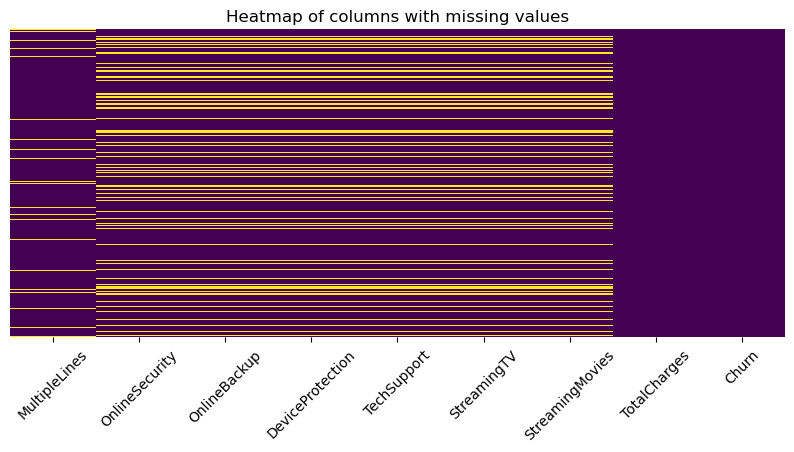

In [17]:
#visualize missingness
plt.figure(figsize=(10, 4))
sns.heatmap(df_3000[nan_columns].isnull(), cmap='viridis', yticklabels=False, cbar=False)
plt.title('Heatmap of columns with missing values')
plt.xticks(rotation=45)

plt.show()

- We observe that the same records have missing values for onlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies.  We refer to these as "smart features".
- This "smart features" seem to be smart phone features. .
- This missingness pattern may have a root cause. We investigate it further

In [18]:
for col in nan_columns:
    print(f'Number of missing values in {col}:{df_3000[col].isnull().sum()} \
    ( {(df_3000[col].isnull().sum() / df_3000.shape[0]) * 100:.2f}% )' )


Number of missing values in MultipleLines:269     ( 8.97% )
Number of missing values in OnlineSecurity:651     ( 21.70% )
Number of missing values in OnlineBackup:651     ( 21.70% )
Number of missing values in DeviceProtection:651     ( 21.70% )
Number of missing values in TechSupport:651     ( 21.70% )
Number of missing values in StreamingTV:651     ( 21.70% )
Number of missing values in StreamingMovies:651     ( 21.70% )
Number of missing values in TotalCharges:5     ( 0.17% )
Number of missing values in Churn:1     ( 0.03% )


In [19]:
# comparing unique values of columns with missing values in first 3000 and last 2000
for col in nan_columns:
    if col != 'TotalCharges':
        print(f"unique values in {col} column of first 3000: {df_3000[col].unique()}")
        print(f"unique values in {col} column of last 2000: {df_2000[col].unique()}")
        print("*******************************************************************")


unique values in MultipleLines column of first 3000: [None False True]
unique values in MultipleLines column of last 2000: ['No' 'No phone service' 'Yes']
*******************************************************************
unique values in OnlineSecurity column of first 3000: [False True None]
unique values in OnlineSecurity column of last 2000: ['No' 'Yes' 'No internet service']
*******************************************************************
unique values in OnlineBackup column of first 3000: [True False None]
unique values in OnlineBackup column of last 2000: ['No' 'Yes' 'No internet service']
*******************************************************************
unique values in DeviceProtection column of first 3000: [False True None]
unique values in DeviceProtection column of last 2000: ['No' 'Yes' 'No internet service']
*******************************************************************
unique values in TechSupport column of first 3000: [False True None]
unique values in TechSup

- Critical observation suggests that 'No internet service' in df_2000 is represented as missing (None) in df_3000.
- People with "No internet service" are likely to be using a "basic phone"
- A basic phone is a mobile phone with little-to-no computing or internet capacity.

In [20]:
smart_features = ["OnlineSecurity", "OnlineBackup", "DeviceProtection",
                    "TechSupport", "StreamingTV", "StreamingMovies"]

In [21]:
df_3000[smart_features + ["InternetService"]][df_3000.OnlineSecurity.isna()]

,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,InternetService
11,None,None,None,None,None,None,No
16,None,None,None,None,None,None,No
21,None,None,None,None,None,None,No
22,None,None,None,None,None,None,No
33,None,None,None,None,None,None,No
...,...,...,...,...,...,...,...
2984,None,None,None,None,None,None,No
2987,None,None,None,None,None,None,No
2989,None,None,None,None,None,None,No
2993,None,None,None,None,None,None,No


- Indeed, people with missing values in the smart features are also without Internet Service.
- clearly the evidence suggests to impute the missing values with 'No internet service'
- Similarly, it makes sense to impute the missing values in MultipleLines with "No phone service" as in the last 2000.
- Based on analysis of the 'TotalCharges' column, we'll decide the imputation.

#### Accuracy: Duplicates, Outliers, Data entry errors.

In [22]:
# no duplicates
print(df_3000.duplicated().sum())
print(df_2000.duplicated().sum())

0
0


In [23]:
# summary statistics
df_3000.TotalCharges.describe()

count    2995.000000
mean     2301.278315
std      2274.987884
min        18.799999
25%       415.250000
50%      1404.650024
75%      3868.725098
max      8564.750000
Name: TotalCharges, dtype: float64

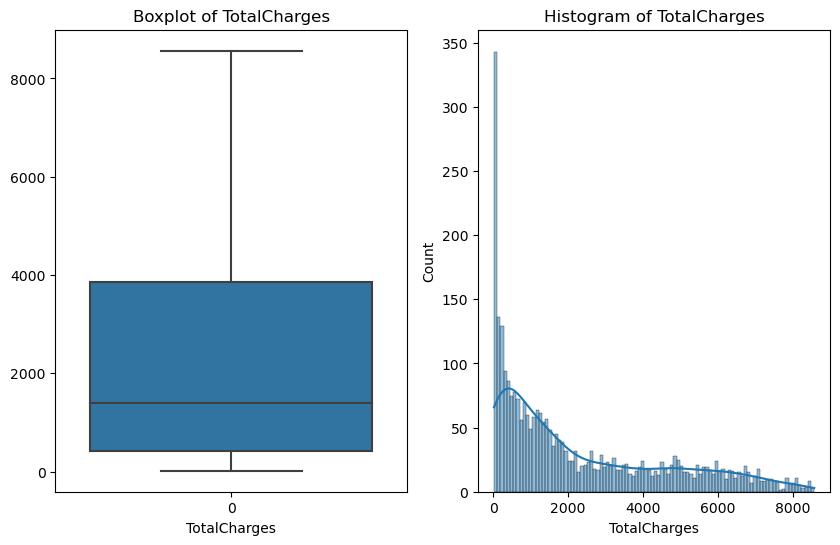

In [24]:
# there are no outliers in TotalCharges but it's distribution is skewed to the right
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
sns.boxplot(data=df_3000.TotalCharges)
plt.xlabel('TotalCharges')
plt.title("Boxplot of TotalCharges")


plt.subplot(1, 2, 2)
sns.histplot(data=df_3000.TotalCharges, bins=100, kde=True)
plt.title("Histogram of TotalCharges")


plt.show()

#### Consistency: Inconsistent formats, Inconsistent categories or labels, Inconsistent representations

In [25]:
print(df_3000.info())
print(df_2000.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        3000 non-null   object 
 1   gender            3000 non-null   object 
 2   SeniorCitizen     3000 non-null   bool   
 3   Partner           3000 non-null   bool   
 4   Dependents        3000 non-null   bool   
 5   tenure            3000 non-null   int64  
 6   PhoneService      3000 non-null   bool   
 7   MultipleLines     2731 non-null   object 
 8   InternetService   3000 non-null   object 
 9   OnlineSecurity    2349 non-null   object 
 10  OnlineBackup      2349 non-null   object 
 11  DeviceProtection  2349 non-null   object 
 12  TechSupport       2349 non-null   object 
 13  StreamingTV       2349 non-null   object 
 14  StreamingMovies   2349 non-null   object 
 15  Contract          3000 non-null   object 
 16  PaperlessBilling  3000 non-null   bool   


In [26]:
df_2000.SeniorCitizen.unique()

array([0, 1], dtype=int64)

#### Data Quality Assessment Report


|          | **Completeness** | **Accuracy** | **Consistency** |
| -------- | -------- | -------- | -------- |
| **first_3000**  | <ul><li>OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies attributes have 21.70% missing values for the same records. We refer to these as "smart features" </li> <li>MultipleLines and TotalCharges have 269(8.97%) and 5(0.17%) missing values respectively. </li> <li>The target variable "Churn" contains 1 missing value</li> </ul>   | <ul> <li>No duplicated records</li></ul>   | <ul> <li>No outliers in TotalCharges. Imputing with mean will be good</li> <li>Inconsistent data types. eg: True/False vs Yes/No</li> <li>"smart features" formatted as Boolean</li> </ul> |
| **last_2000**   | <li>No missing values </li> | <ul> <li>No duplicated records</li> </ul>  </ul>  | <li>Inconsistent data types. eg: Yes/No vs 0/1.</li> <li>TotalCharges formated as string</li> <li>"smart features" formated as string</li>|


**Comments on Identified Data Quality issues**
    
 | **Completeness** | **Accuracy** | **Consistency** |
 | -------- | -------- | -------- |
 |   <ul> <li>Comparing unique values in last 2000 dataset and exploring the "InternetService" attribute, we found enough evidence to impute the "smart features" missing values with "No internet service" </li> <li>"MultipleLines" column will be imputed with "No phone service" as in last 2000</li> <li>"TotalCharges" will be replaced with the median </li> <li>record with "Churn" missing will be dropped</li> </ul>       |  <ul><li>Dataset appears to be quite Accurate</li></ul>         |  <ul><li>We'll reformat SeniorCitizen values from 1/0 to Yes/No in the last 2000 data</li> <li>All boolean columns will be reformtted to Yes/No</li> </ul> |

### Data Selection

In [28]:
# make a copy before cleaning
Newdf_3000 = df_3000.copy()
Newdf_2000 = df_2000.copy()

In [29]:
#drop customerID column.
Newdf_2000.drop('customerID', axis=1, inplace=True)
Newdf_3000.drop('customerID', axis=1, inplace=True)

### Data Cleaning

In [30]:
# imputing missing values for "smart features"
Newdf_3000[smart_features] = Newdf_3000[smart_features].fillna( "No internet service" )

#imputing missing values for MultipleLines
Newdf_3000["MultipleLines"] = Newdf_3000.MultipleLines.fillna( "No phone service" )

#imputing missing values for TotalCharges
Newdf_3000["TotalCharges"] = Newdf_3000.TotalCharges.fillna(Newdf_3000.TotalCharges.mean())

#delete record containing missing churn value
Newdf_3000 = Newdf_3000.dropna(subset=["Churn"])

#replace 0/1 in SeniorCitizen in last 2000
Newdf_2000["SeniorCitizen"] = Newdf_2000.SeniorCitizen.replace({1:"Yes", 0:"No"})

#reformatting boolean columns
Newdf_3000.replace( {True:"Yes", False:"No"}, inplace=True )

#merge datasets
df_train = pd.concat([Newdf_3000, Newdf_2000], axis=0 ).reset_index(drop=True)
df_train.shape

(5042, 20)

In [31]:
#smart features imputed
df_train[smart_features].isna().any()


OnlineSecurity      False
OnlineBackup        False
DeviceProtection    False
TechSupport         False
StreamingTV         False
StreamingMovies     False
dtype: bool

In [32]:
# boolean columns changed
df_train.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850000,29.85,No
1,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950001,1889.5,No
2,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.849998,108.150002,Yes
3,Male,No,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.299999,1840.75,No
4,Female,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.699997,151.649994,Yes


In [33]:
#SeniorCitizen values changed
df_train.tail()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
5037,Male,No,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
5038,Female,No,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
5039,Female,No,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
5040,Male,Yes,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes
5041,Male,No,No,No,66,Yes,No,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),105.65,6844.5,No


In [34]:
# row with missing Churn value dropped
df_train[df_train.Churn.isna()]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn


In [35]:
# data cleaned
df_train.isna().any().sum()

0

### Data Formatting

In [36]:
df_train.dtypes

gender               object
SeniorCitizen        object
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

TotalCharges is expected to be of type float, but has been casted to object. This might be because of an unexpected non-numeric value.

In [37]:
# unexpected value in TotalCharges column
df_train[df_train["TotalCharges"] == " "]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
3217,Male,No,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
4669,Female,No,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No
4753,Male,No,No,Yes,0,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),61.90,,No


In [38]:
df_train.TotalCharges = pd.to_numeric(df_train.TotalCharges, errors='coerce') #converts " " to NaN
df_train.TotalCharges = df_train.TotalCharges.fillna(df_train.TotalCharges.median())

## EXPLORATORY DATA ANALYSIS
In his book, The Art of Data Science, Peng asserted that EDA process can result in an exponential number of paths that can be taken with any sizeable dataset and that a sharp question or hypothesis can serve as a dimension reduction tool that can eliminate variables that are not immediately relevant to the question.

Guided by our research question/hypothesis, the aim of the EDA to gain insights into the patterns, trends and relationships related to customer churn.  EDA will help in understanding the distribution of features and identifying correlations relative to the customer churn.

### Univariate Analysis


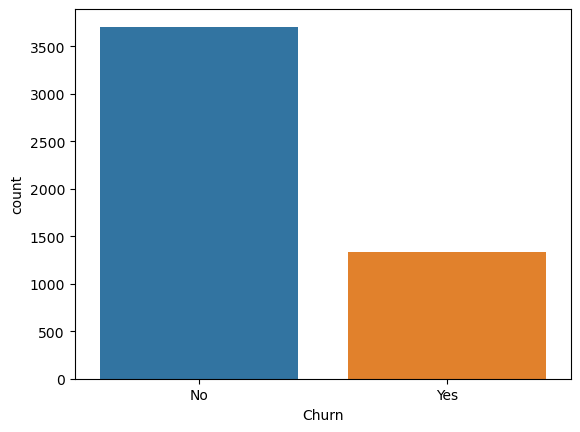

In [39]:
#verify class balance of target variable
sns.countplot(data=df_train, x='Churn' );

In [40]:
#proportion of Yes class
yes_proportion = len( df_train[ df_train['Churn'] == 'Yes'] ) / df_train.shape[0]
print(f'Percentage of observations belonging to Churn class: {yes_proportion:.2f}%')

Percentage of observations belonging to Churn class: 0.26%


We notice there's the problem of class imbalance. Using appropriate statistical tests becomes necessary as some statistical tests are more robust to class imbalance than others. For instance, the Mann-Whitney U test and the Kruskal-Wallis test are non-parametric tests that can handle imbalanced data better than parametric tests like the t-test.


### Bivariate Analysis
Investigate feature relationship with target

In [41]:
# Extract numerical columns
numeric_columns = df_train.select_dtypes(exclude=['object'])
numeric_columns.head()

,tenure,MonthlyCharges,TotalCharges
0,1,29.850000,29.850000
1,34,56.950001,1889.500000
2,2,53.849998,108.150002
3,45,42.299999,1840.750000
4,2,70.699997,151.649994


In [42]:
numeric_columns.tail()

,tenure,MonthlyCharges,TotalCharges
5037,24,84.80,1990.50
5038,72,103.20,7362.90
5039,11,29.60,346.45
5040,4,74.40,306.60
5041,66,105.65,6844.50


In [43]:
## summary statistics of numerical columns
numeric_columns.describe()

,tenure,MonthlyCharges,TotalCharges
count,5042.000000,5042.000000,5042.000000
mean,32.568822,65.081376,2300.421776
std,24.525954,30.064564,2266.651173
min,0.000000,18.400000,18.799999
25%,9.000000,35.762500,417.875000
50%,29.000000,70.550003,1404.650024
75%,56.000000,90.050002,3857.012573
max,72.000000,118.650002,8670.100000


We create visualizations such as  boxplots, countplots, and histograms to compare the distributions of categorical and numerical variables between the two groups.

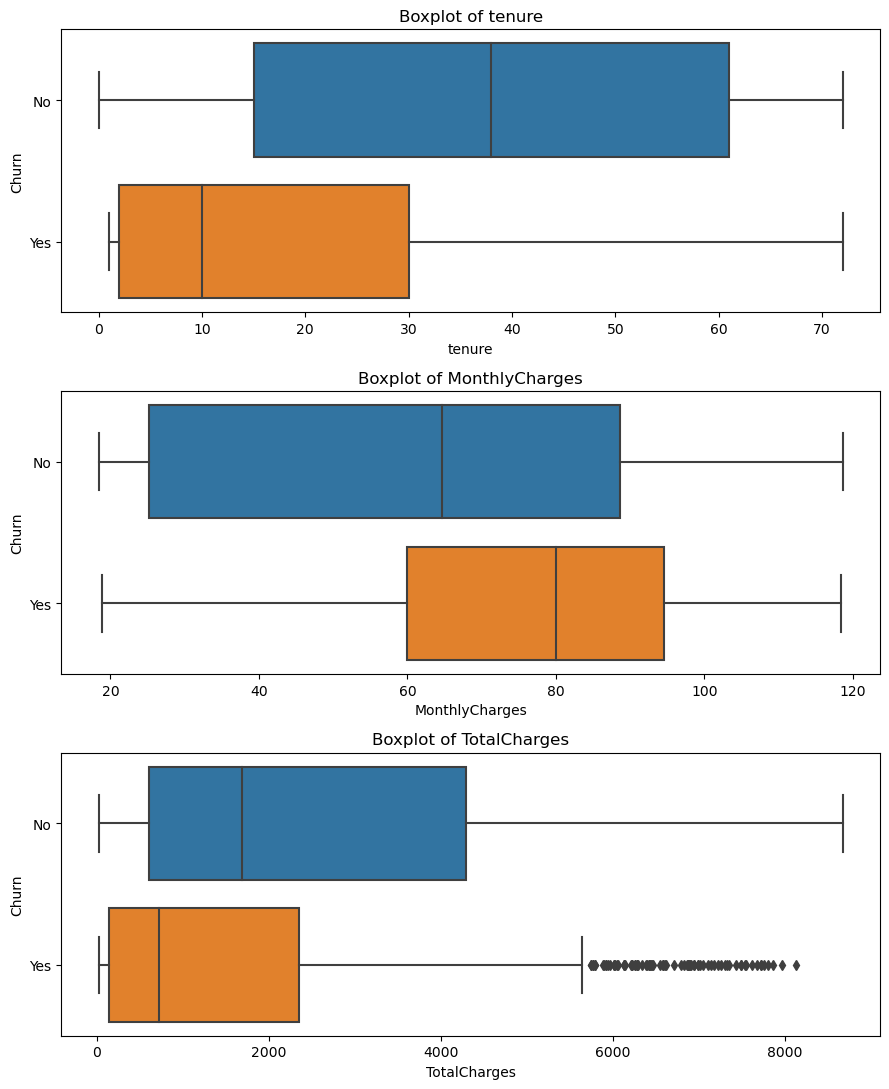

In [44]:
#comparing distributions between the two groups of Churn for the numerical columns.
#set up fig and axes
fig, axes = plt.subplots(nrows=3, ncols= 1, figsize=(9, 11))

#plot boxplot of two groups
for i, num_var in enumerate(numeric_columns):
    sns.boxplot(data=df_train, x=num_var, y='Churn', ax=axes[i]);
    axes[i].set_title(f'Boxplot of {num_var}')

plt.tight_layout()


#### Statistical Tests
We perform an independent samples test to determine if the apparent difference between customers who churn and customers who do not is significant for each of the numerical variables.

If the p-value is less than a chosen significance level (0.05), you can reject the null hypothesis and conclude that there is a statistically significant difference in the central tendencies of the predictor variable for customers who churn and those who do not.

In other words, the predictor variable has a statistically significant effect on the target variable.

Checking the 2 main assumptions of independent samples t-tests:
 - Normality: The data in each group should be approximately normally distributed.

 - Homogeneity of variances: The variances of the data in both groups should be equal.



In [45]:
#### define function to separate two classes of Churn
def group_separator(var):
    group_no = df_train[df_train.Churn == 'No'][var]
    group_yes = df_train[df_train.Churn == 'Yes'][var]

    return var, group_no, group_yes

predictor_var, group_no, group_yes = group_separator(var='tenure')

print(predictor_var)
print(group_no.head())
print(group_yes.head())


tenure
0     1
1    34
3    45
6    22
7    10
Name: tenure, dtype: int64
2      2
4      2
5      8
8     28
13    49
Name: tenure, dtype: int64


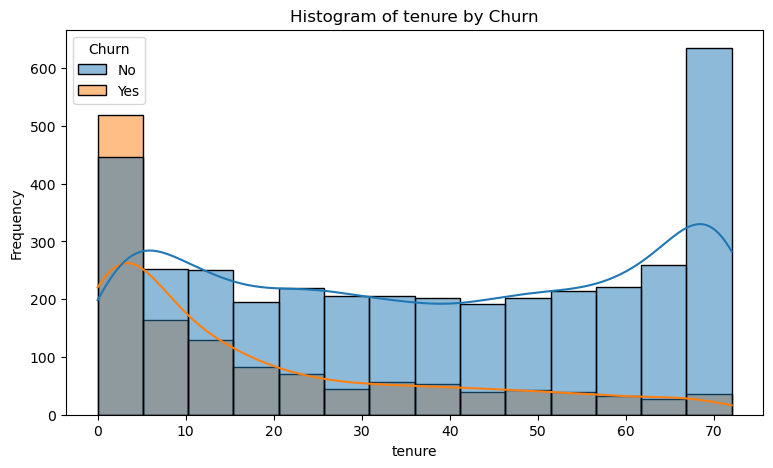

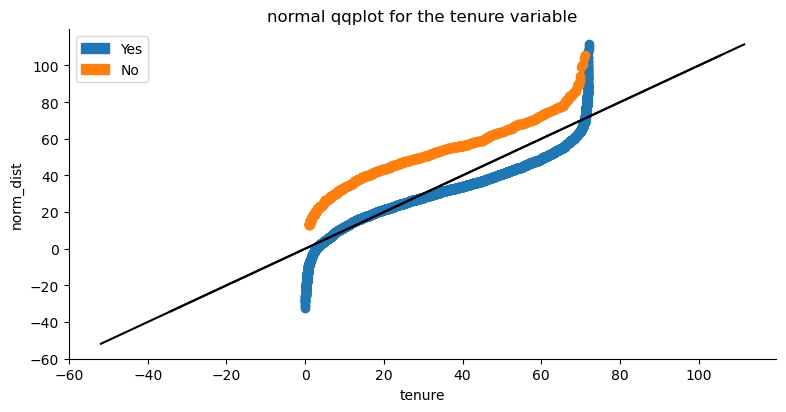

In [46]:
### normality check visualization
### Define function to plot histogram and qq plot
def hist_qqplot(var):
    fig= plt.figure( figsize=(9, 5) )

    ax = fig.add_subplot(111)
    sns.histplot(data=df_train, kde=True, x=var, hue='Churn');
    ax.set_title(f'Histogram of {var} by Churn');
    ax.set_ylabel('Frequency');

    pplot(df_train, x=var, y=norm, kind='qq', hue='Churn',
                    height=4, aspect=2, display_kws={'identity':True});
    plt.title(f'normal qqplot for the {var} variable');

hist_qqplot(var='tenure')

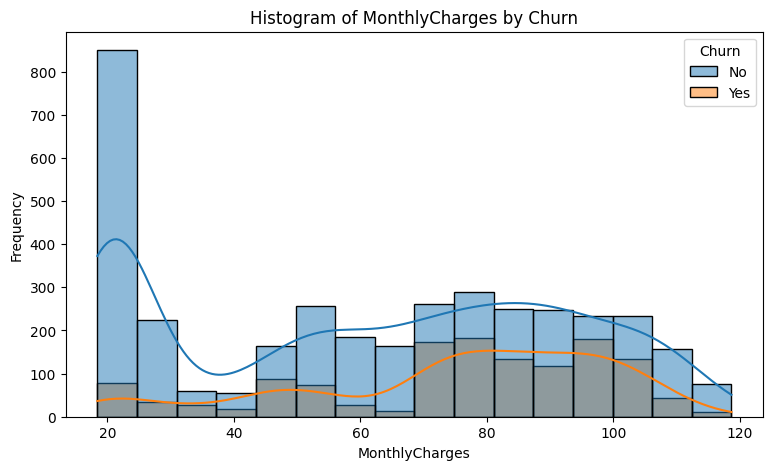

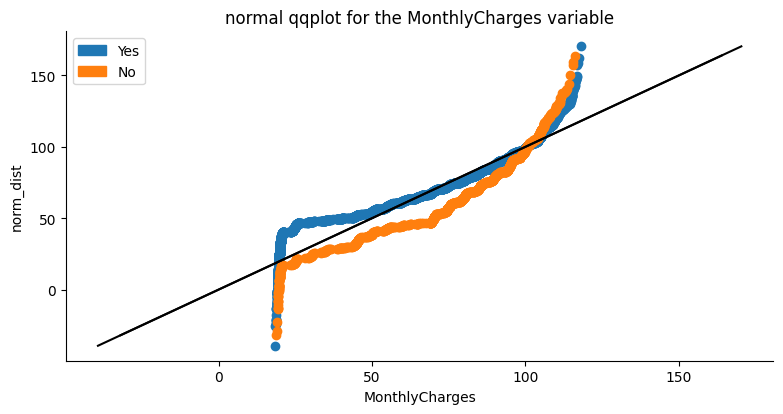

In [47]:
hist_qqplot(var='MonthlyCharges')

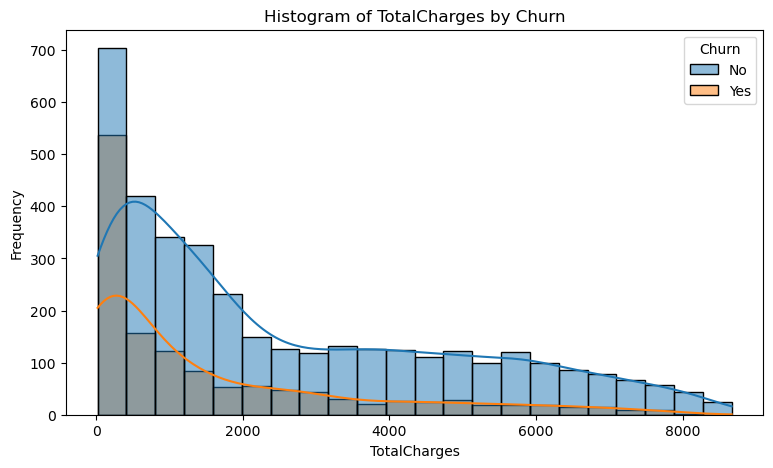

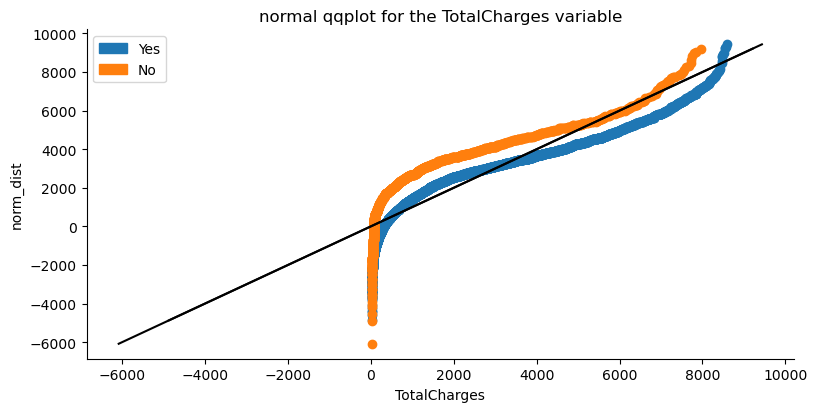

In [47]:
hist_qqplot(var='TotalCharges')

Because of the deviation from normality and class imbalance, non-parametric test will be used.

Unlike the t-test, which compares means, the Mann-Whitney U test compares the distributions of two groups to determine if they have the same population distribution or if one tends to have larger values than the other.

In other words, the Mann-Whitney U test assesses whether the two groups differ significantly in terms of their central tendencies or location. It does not directly compare means, but it evaluates whether the two groups have the same underlying population distribution.

In [48]:
# mann whitney u test function for numerical variables
alpha = 0.05

def mannwhiteyTest(var, group1, group2):

    _, p_value = stats.mannwhitneyu(group1, group2, alternative='two-sided')

    print(f'Mann-Whitney U Test Results for {var}')
    print( f'p_value: {p_value}' )

    if p_value < alpha:
        print(f"Decision: There's  SIGNIFICANT DIFFERENCE in {var} between customers who churn and those who do not")
    else:
        print(f"Decision: There's NO SIGNIFICANT DIFFERENCE in {var} between customers who churn and those who do not")

mannwhiteyTest(var=predictor_var, group1=group_no, group2=group_yes)

Mann-Whitney U Test Results for tenure
p_value: 2.323659043149809e-148
Decision: There's  SIGNIFICANT DIFFERENCE in tenure between customers who churn and those who do not


In [49]:
predictor_var, group_no, group_yes = group_separator(var='MonthlyCharges')
mannwhiteyTest(var=predictor_var, group1=group_no, group2=group_yes)

Mann-Whitney U Test Results for MonthlyCharges
p_value: 9.485110331550752e-43
Decision: There's  SIGNIFICANT DIFFERENCE in MonthlyCharges between customers who churn and those who do not


In [50]:
predictor_var, group_no, group_yes = group_separator(var='TotalCharges')
mannwhiteyTest(var=predictor_var, group1=group_no, group2=group_yes)

Mann-Whitney U Test Results for TotalCharges
p_value: 9.38027383036229e-59
Decision: There's  SIGNIFICANT DIFFERENCE in TotalCharges between customers who churn and those who do not


The statistical tests performed suggests that the numerical features significantly impact the Churn variable.


In [51]:
cat_columns = df_train.select_dtypes(exclude=['float', 'int'])
print(len(cat_columns.columns))
cat_columns.head()

17


,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
0,Female,No,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,No
1,Male,No,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,No
2,Male,No,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,Yes
3,Male,No,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),No
4,Female,No,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,Yes


In [52]:
cat_columns.tail()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
5037,Male,No,Yes,Yes,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,No
5038,Female,No,Yes,Yes,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),No
5039,Female,No,Yes,Yes,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,No
5040,Male,Yes,Yes,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,Yes
5041,Male,No,No,No,Yes,No,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),No


In [53]:
cols = list(cat_columns.columns)
cols.remove('Churn')

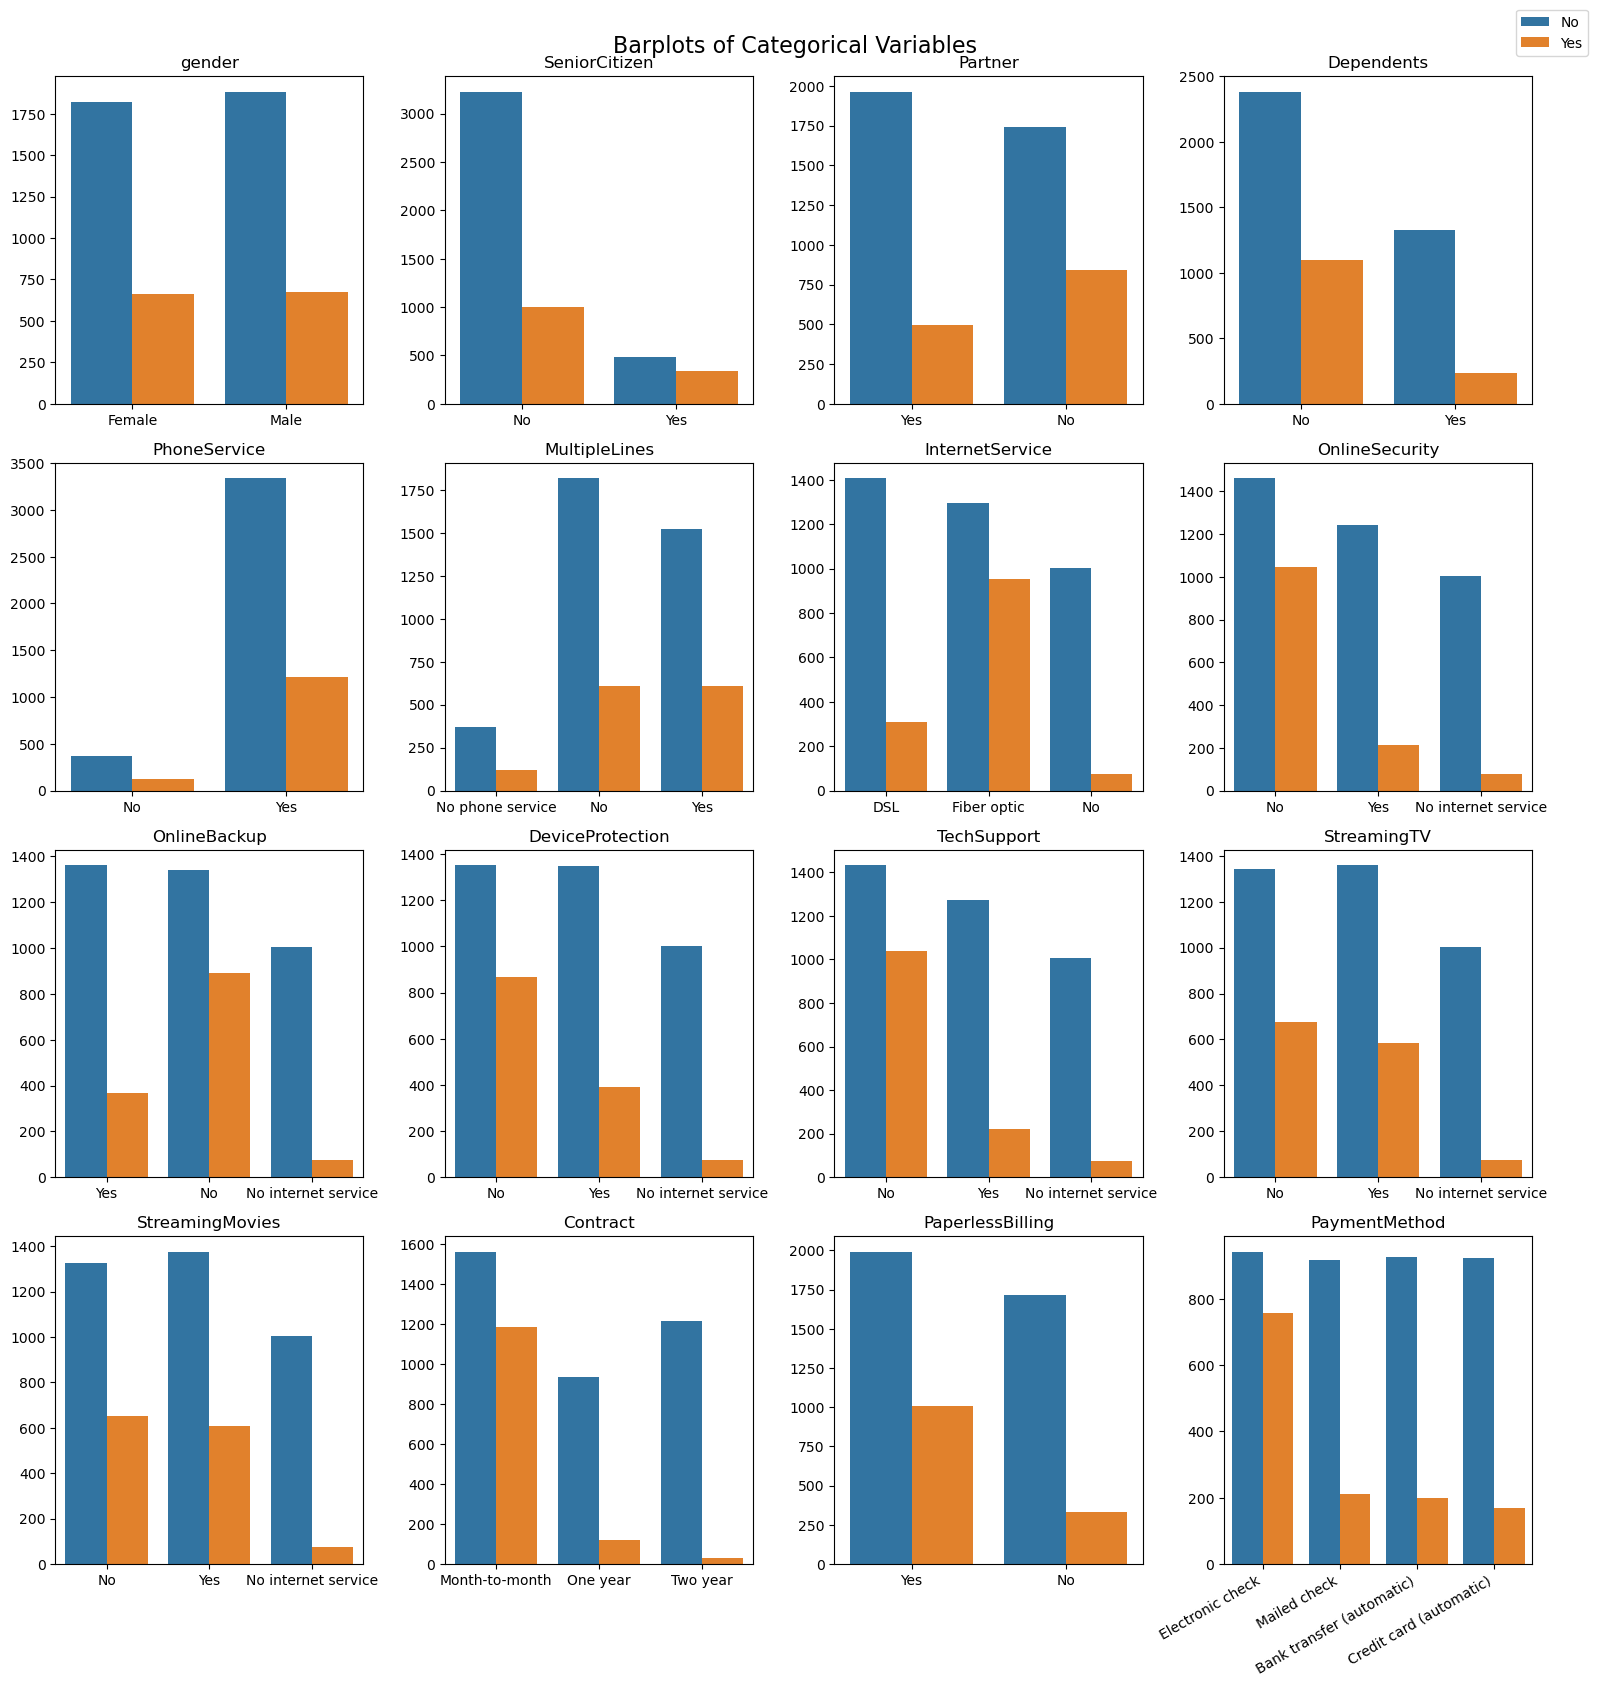

In [54]:

# set up figure and axes
fig, axes = plt.subplots(nrows=4, ncols=4, sharex=False, sharey=False, figsize=(16, 16))
fig.suptitle('Barplots of Categorical Variables', fontsize=16)

#flatten axes array to loop through
axes = axes.flatten()

#access axes and create barplots
for i, cat_var  in enumerate(cols):
    ax = sns.countplot(data=cat_columns, x=cat_var, ax=axes[i], hue='Churn');
    ax.legend().set_visible(False)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    axes[i].set_title(cat_var)


# Add a single legend for all the countplots outside the grid
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.xticks(rotation=30, ha='right');

#### chi square test of independence

The Chi-Square test of independence is used to determine whether there is a significant association or relationship between two categorical variables.  We test whether some of the categorical variables are independent of Customer Churn.  

The test helps you assess whether the observed frequencies in the table differ significantly from the expected frequencies under the assumption of independence between the two variables.

In [55]:
significant_variables = []
insignificant_variables = []

def chi_square_test(var):

    # Create a contingency table (cross-tabulation) of the two categorical variables
    contingency_table = pd.crosstab(df_train[var], df_train['Churn'])

    # Perform the Chi-Square test of independence
    chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

    # Print the results
    print(f'{var}')
    print(f"Chi-Square Test of Independence Results:")
    print("Chi-Square Statistic:", chi2_stat)
    print("p-value:", p_value)
    print("Degrees of Freedom:", dof)
    print("Expected Frequencies Table:")
    print(pd.DataFrame(expected, index=contingency_table.index, columns=contingency_table.columns))

    # Interpret the results
    alpha = 0.05
    if p_value < alpha:
        print(f"There is a SIGNIFICANT RELATIONSHIP between {var} and Churn.")
        significant_variables.append(var)
    else:
        print(f"There is NO SIGNIFICANT RELATIONSHIP between {var} and Churn.")
        insignificant_variables.append(var)

In [56]:
for col in cols:
    chi_square_test(var=col)
    print("****" * 20)

gender
Chi-Square Test of Independence Results:
Chi-Square Statistic: 0.021628520637713346
p-value: 0.8830796247912641
Degrees of Freedom: 1
Expected Frequencies Table:
Churn            No         Yes
gender                         
Female  1825.804046  658.195954
Male    1880.195954  677.804046
There is NO SIGNIFICANT RELATIONSHIP between gender and Churn.
********************************************************************************
SeniorCitizen
Chi-Square Test of Independence Results:
Chi-Square Statistic: 112.2962875886836
p-value: 3.0771132702736696e-26
Degrees of Freedom: 1
Expected Frequencies Table:
Churn                   No          Yes
SeniorCitizen                          
No             3104.013883  1118.986117
Yes             601.986117   217.013883
There is a SIGNIFICANT RELATIONSHIP between SeniorCitizen and Churn.
********************************************************************************
Partner
Chi-Square Test of Independence Results:
Chi-Square Statistic: 9

In [57]:
print('Insignificant variables: ', insignificant_variables)
print()
print('Significant Variables: ')
significant_variables

Insignificant variables:  ['gender', 'PhoneService']

Significant Variables: 


['SeniorCitizen',
 'Partner',
 'Dependents',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

All but gender and PhoneService seem not to have influence on whether a customer churns or not. We therefore Reject the Null hypothesis of our general hypothesis and conclude that there's significant differences in the behaviours and characteristics of customers who churn and those who do not.


### Multivariate Analysis

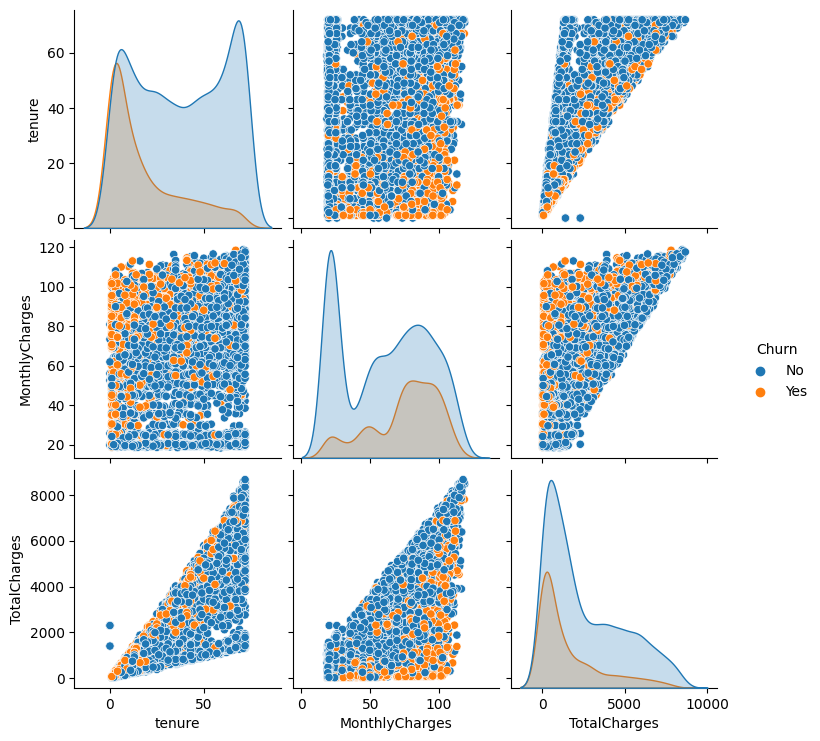

In [59]:
sns.pairplot(df_train, hue='Churn');

 - clusters are not clearly distinct but we do see some areas where each of the two groups dominate.  
 - Also, some noticeable differences in the distribution of the numerical variables of those who churned and those who didn't.
- There appears to be weak correlation between the numerical variables.
  

In [60]:
# correlation analysis
correlation_matrix = numeric_columns.corr()
correlation_matrix


,tenure,MonthlyCharges,TotalCharges
tenure,1.000000,0.240287,0.825303
MonthlyCharges,0.240287,1.000000,0.646449
TotalCharges,0.825303,0.646449,1.000000


<Axes: >

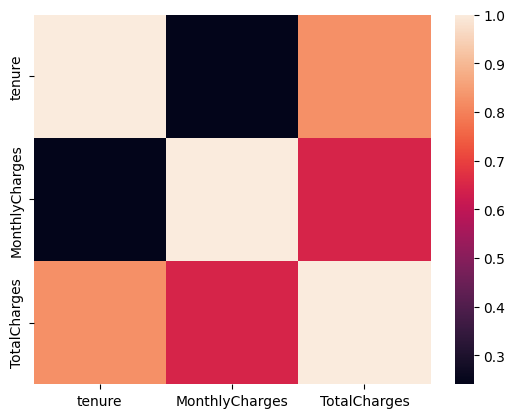

In [61]:
sns.heatmap(data=correlation_matrix)

The strong correlation between tenure and TotalCharges is expected as the longer one uses the service the more their TotalCharges. Similarly, for the observed moderate correlation between MonthlyCharges and TotalCharges.

### Summary of Exploraratory Analysis

EDA was aimed to identify key factors that contribute to customer churn and gain insights into the characteristics and behaviors of churned customers. The following are a summary of insights into patterns, trends, and relationship obtained:

1. Churn is class imbalanced.
2. Except for gender and phone service, all the variables had a statistically significant influence on customer churn.
3. some correlations exists between numerical columns.




### Answer to Data Mining Goals

### *Questions*
1. What is the overall churn rate in the dataset?

2. How does the churn rate vary between male and female customers (gender)?

3. Does the presence of additional services like OnlineSecurity, TechSupport, DeviceProtection, StreamingTV, or StreamingMovies influence customer churn rates?

4. Is there a correlation between customer tenure (length of subscription) and the likelihood of churn?

5.  What is the impact of internet service type (DSL or Fiber optic) on customer churn?

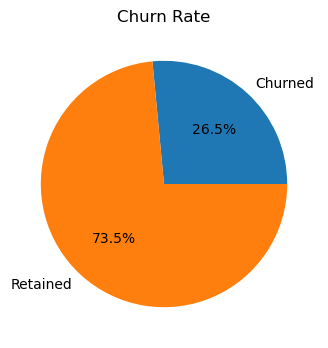

Overall Churn Rate: 26.50%


In [58]:
#answer 1
churned_customers = df_train['Churn'].value_counts()[1]  # As'Churn' contains binary values (0 and 1)
total_customers = len(df_train)

# Calculate the churn rate
churn_rate = (churned_customers / total_customers) * 100

# Visualize the churn rate using a pie chart
plt.figure(figsize=(6, 4))
plt.pie([churned_customers, total_customers - churned_customers],
        labels=['Churned', 'Retained'], autopct='%1.1f%%')
plt.title('Churn Rate')
plt.show()

print(f"Overall Churn Rate: {churn_rate:.2f}%")

To Calculate the overall churn rate in the dataset as the percentage of customers who have stopped using a service or product. In our dataset, we need to determine the number of churned customers and divide it by the total number of customers to get the churn rate.  and then we visualize it by Pie Chart to show us a clear proportional distribution among the Retained customers and the ones who churned, therefore, from the observation we see that the customers churned at 26.5% while those who did not churn was at 73.5%.

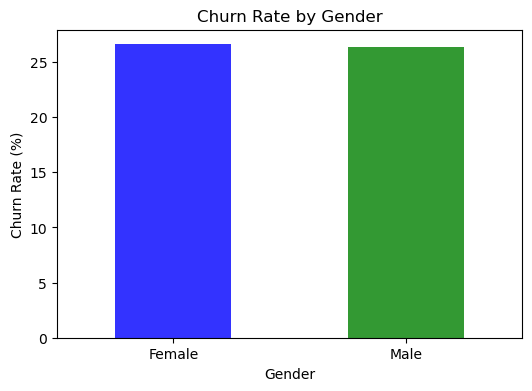

Churn Rate by Gender:
gender
Female    26.610306
Male      26.387803
Name: Churn, dtype: float64


In [59]:
#Ans2

# Convert the 'Churn' column to binary values (1 for 'Yes' and 0 for 'No')

df_train['Churn'] = df_train['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)
# we calculate the mean of the 'Churn' column for each group, which gives us the churn rate for male and female customers separately.
churn_by_gender = df_train.groupby('gender')['Churn'].mean() *100

# Visualize the churn rate by gender using a bar chart
plt.figure(figsize=(6, 4))
churn_by_gender.plot(kind='bar', color=['blue', 'green'], alpha=0.8)
plt.xlabel('Gender')
plt.ylabel('Churn Rate (%)')
plt.title('Churn Rate by Gender')
plt.xticks(rotation=0)
plt.show()

print("Churn Rate by Gender:")
print(churn_by_gender)

The variations of churn Rate among the gender(Female and Male Customers) varies as above but the the Female churned at high rate than Male as they churned at 26.61% while Male Churned at 26.38%.

In [60]:
#Ans3
# Calculate the churn rates for customers with and without each additional service
additional_services = ['OnlineSecurity', 'TechSupport', 'DeviceProtection', 'StreamingTV', 'StreamingMovies']
churn_rates_by_service = {}

for service in additional_services:
    has_service_churn_rate = df_train[df_train[service] == 'Yes']['Churn'].mean()
    no_service_churn_rate = df_train[df_train[service] == 'No']['Churn'].mean()

    churn_rates_by_service[service] = {
        'Has_Service': has_service_churn_rate,
        'No_Service': no_service_churn_rate
    }

# Print the churn rates for each additional service
print("Churn Rates by Additional Services:")
for service, rates in churn_rates_by_service.items():
    print(f"{service}:")
    print(f"Churn Rate with {service}: {rates['Has_Service']:.2f}%")
    print(f"Churn Rate without {service}: {rates['No_Service']:.2f}%")
    print()

Churn Rates by Additional Services:
OnlineSecurity:
Churn Rate with OnlineSecurity: 0.15%
Churn Rate without OnlineSecurity: 0.42%

TechSupport:
Churn Rate with TechSupport: 0.15%
Churn Rate without TechSupport: 0.42%

DeviceProtection:
Churn Rate with DeviceProtection: 0.23%
Churn Rate without DeviceProtection: 0.39%

StreamingTV:
Churn Rate with StreamingTV: 0.30%
Churn Rate without StreamingTV: 0.33%

StreamingMovies:
Churn Rate with StreamingMovies: 0.31%
Churn Rate without StreamingMovies: 0.33%



we used a grouped bar chart allows us to compare multiple categories side by side, making it suitable for comparing the churn rates of customers with and without each service.

<Figure size 1000x600 with 0 Axes>

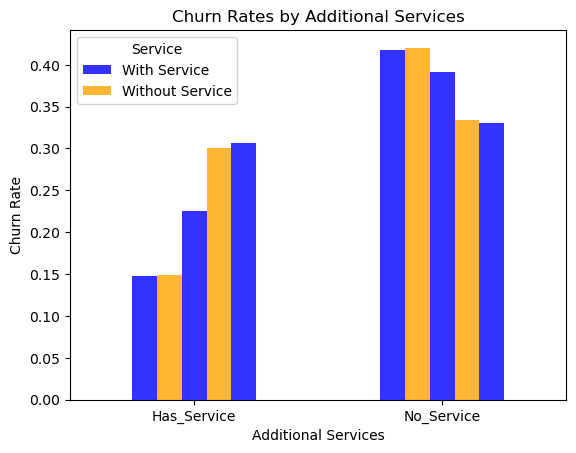

In [61]:
# Convert the churn rates to a pandas DataFrame
churn_df = pd.DataFrame(churn_rates_by_service)
# Visualize the churn rates using a grouped bar chart
plt.figure(figsize=(10, 6))
churn_df.plot(kind='bar', color=['blue', 'orange'], alpha=0.8)
plt.xlabel('Additional Services')
plt.ylabel('Churn Rate')
plt.title('Churn Rates by Additional Services')
plt.xticks(rotation=0)
plt.legend(title='Service', labels=['With Service', 'Without Service'])
plt.show()

In [62]:
# Ans4
# let calculate the point-biserial correlation coefficient and p-value
correlation_coefficient, p_value = stats.pointbiserialr(df_train['Churn'], df_train['tenure'])

# Print the correlation coefficient and p-value
print("Point-Biserial Correlation Coefficient:", correlation_coefficient)
print("P-value:", p_value)

# Interpretation
if p_value < 0.05:  # Assuming a significance level of 0.05
    if correlation_coefficient > 0:
        print("There is a significant positive correlation between customer tenure and churn.")
    elif correlation_coefficient < 0:
        print("There is a significant negative correlation between customer tenure and churn.")
    else:
        print("There is no significant correlation between customer tenure and churn.")
else:
    print("The correlation is not statistically significant.")


Point-Biserial Correlation Coefficient: -0.35077175688675066
P-value: 6.502708225624357e-146
There is a significant negative correlation between customer tenure and churn.


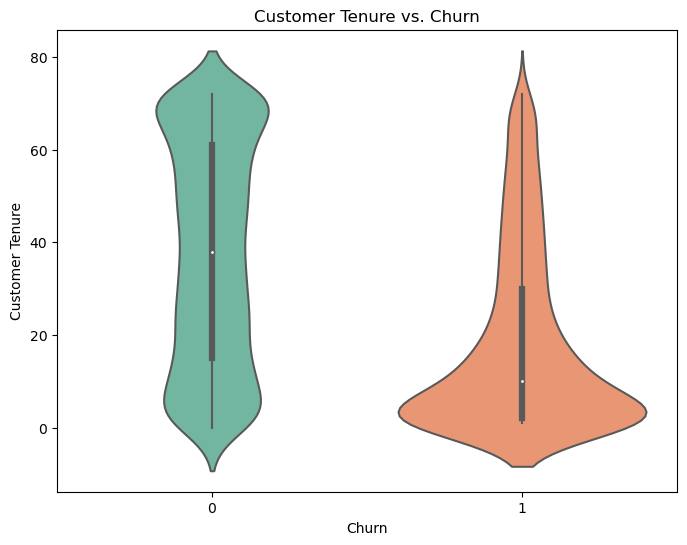

In [63]:
# Create a violin plot
plt.figure(figsize=(8, 6))
sns.violinplot(x='Churn', y='tenure', data=df_train, palette='Set2')
plt.xlabel('Churn')
plt.ylabel('Customer Tenure')
plt.title('Customer Tenure vs. Churn')
plt.show()

The plot shows a significant overlap between the two violins, it suggests that customer tenure may not be strongly associated with the likelihood of churn and suggests that there is a weaker correlation between these two variables.

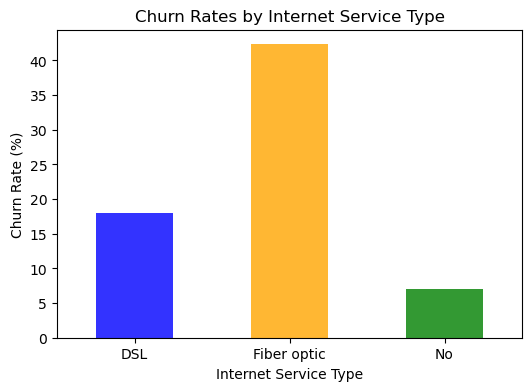

Churn Rates by Internet Service Type:
DSL: 18.02%
Fiber optic: 42.32%
No: 7.04%


In [64]:
#ans5
# Calculate the churn rates for each internet service type
churn_rate_by_service = df_train.groupby('InternetService')['Churn'].mean() * 100

# Visualize the churn rates for each internet service type using a bar chart
plt.figure(figsize=(6, 4))
churn_rate_by_service.plot(kind='bar', color=['blue', 'orange','green'], alpha=0.8)
plt.xlabel('Internet Service Type')
plt.ylabel('Churn Rate (%)')
plt.title('Churn Rates by Internet Service Type')
plt.xticks(rotation=0)
plt.show()

# Print the churn rates for each internet service type
print("Churn Rates by Internet Service Type:")
for Service, Churn_Rate in churn_rate_by_service.items():
    print(f"{Service}: {Churn_Rate:.2f}%")

The Internet Service may have an impact on the customer Churn as DSL may have a least impact compared to the Fiber optic on the customer churn where the DSL may lead to customer churn by 18.02% churn rate while the Fiber optic may lead to 42.32% while 7.04% may churn without using both of the service.

In [65]:
churn_data = df_train.copy()
churn_data.to_csv('churn_data.csv', index=False)

In [66]:
churn_data.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

### FEATURE PREPROCESSING AND ENGINEERING
Based on insights gained from EDA,  Here is the section to **clean**, **process** the dataset and **create new features**.


#### Feature preprocessing

From EDA, we realized that gender and phone service do not have significant impact on Churn. We drop them.  


In [64]:
#drop duplicates
df_train = df_train.drop_duplicates()
df_train.duplicated().sum()

0

In [65]:
#drop gender and phone service.
df_train = df_train.drop(['gender', 'PhoneService'], axis=1)
df_train.columns

Index(['SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges',
       'Churn'],
      dtype='object')

In [66]:
# train test split. split data into train and eval set to maintain integrity of test set
X = df_train.drop('Churn', axis=1)
y = df_train['Churn']

In [67]:
print(X.shape, y.shape)
#print(X_train.shape, X_eval.shape)

(5032, 17) (5032,)


In [68]:
#extract numerical and categorical features
cat_cols = list(X.select_dtypes(include='object').columns)
num_cols = list(X.select_dtypes(exclude='object').columns)

In [69]:
#reorder columns
X = X[num_cols + cat_cols]
print(X.columns)

Index(['tenure', 'MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'Partner',
       'Dependents', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod'],
      dtype='object')


Class imbalance can heavily skew the learning process, causing the model to focus more on the majority class and neglect the minority class.By addressing imbalance first, we create a more level playing field for our model to learn from the data.

We balance the dataset before splitting it into training and testing sets to ensure that both the training and testing sets have a representative distribution of the classes in our dataset. If you balance the dataset after splitting, we may end up with an imbalanced training or testing set, which can negatively impact the performance of our model.



The algorigorithm for balancing the dataset requires that categorical columns are encoded. We therefore encode our dataset first by building a categorical preprocessor pipeline.

In [70]:
#define preprocessing for categorical features
cat_transformer = Pipeline(steps=[
    ('cat_imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore') )
])


In [71]:
X.head()

,tenure,MonthlyCharges,TotalCharges,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod
0,1,29.850000,29.850000,No,Yes,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check
1,34,56.950001,1889.500000,No,No,No,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check
2,2,53.849998,108.150002,No,No,No,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check
3,45,42.299999,1840.750000,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic)
4,2,70.699997,151.649994,No,No,No,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check


In [72]:
# we don't do any numerical transformations to prevent data leakage before splitting.

cat_preprocessor = ColumnTransformer(transformers=[
   ('Num_transformer', 'passthrough', num_cols),
   ('cat_transformer', cat_transformer, cat_cols)

])


In [73]:
X_prepared = cat_preprocessor.fit_transform(X)


In [74]:
#obtain transformed cat_cols columns
transformed_columns = (num_cols +
   list(cat_preprocessor.named_transformers_['cat_transformer'].named_steps['encoder'].get_feature_names_out(cat_cols) ))
len(transformed_columns)

42

In [75]:
#convert to dataframe
X_prepared = pd.DataFrame(X_prepared, columns=transformed_columns)
X_prepared.head()

,tenure,MonthlyCharges,TotalCharges,SeniorCitizen_No,SeniorCitizen_Yes,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,MultipleLines_No,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1.0,29.850000,29.850000,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,34.0,56.950001,1889.500000,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,2.0,53.849998,108.150002,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,45.0,42.299999,1840.750000,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,2.0,70.699997,151.649994,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [76]:
# handling class imbalance
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=99)
X_balanced, y_balanced= smote.fit_resample(X_prepared, y)
print(X_balanced.shape, y_balanced.shape)

(7402, 42) (7402,)


In [77]:
#split dataset
#set stratify=y to ensure minority class is well represented in both sets.
X_train, X_eval, y_train, y_eval = train_test_split(X_balanced, y_balanced, test_size=0.2,
                                                    stratify=y_balanced, random_state=99)

In [78]:
print('shape of trainset: ', X_train.shape, y_train.shape)
print('shape of evaluation set: ', X_eval.shape, y_eval.shape)

shape of trainset:  (5921, 42) (5921,)
shape of evaluation set:  (1481, 42) (1481,)


In [79]:
#build numerical transformer pipeline after splitting data

num_transformer = Pipeline(steps=[
    ('num_imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
  ])

X_train[num_cols] = num_transformer.fit_transform(X_train[num_cols])
X_train

,tenure,MonthlyCharges,TotalCharges,SeniorCitizen_No,SeniorCitizen_Yes,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,MultipleLines_No,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
6704,-0.798500,-1.548498,-0.850566,0.427755,0.572245,0.427755,0.572245,1.0,0.0,0.572245,...,0.0,1.0,0.0,0.0,0.572245,0.427755,0.000000,0.427755,0.000000,0.572245
2602,-1.127563,0.038745,-0.915808,0.000000,1.000000,1.000000,0.000000,1.0,0.0,1.000000,...,0.0,1.0,0.0,0.0,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
5552,-0.855384,0.738870,-0.645817,1.000000,0.000000,1.000000,0.000000,1.0,0.0,0.000000,...,1.0,1.0,0.0,0.0,1.000000,0.000000,0.502289,0.000000,0.000000,0.497711
5589,-0.655095,1.071334,-0.380478,0.712848,0.287152,0.712848,0.287152,1.0,0.0,0.287152,...,1.0,1.0,0.0,0.0,0.000000,1.000000,0.712848,0.000000,0.287152,0.000000
4034,-1.043845,-0.998687,-0.887863,1.000000,0.000000,1.000000,0.000000,1.0,0.0,0.000000,...,0.0,1.0,0.0,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3805,-0.499679,-1.683883,-0.796467,1.000000,0.000000,1.000000,0.000000,1.0,0.0,1.000000,...,0.0,1.0,0.0,0.0,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
3614,-0.206666,1.240904,0.183850,1.000000,0.000000,1.000000,0.000000,1.0,0.0,0.000000,...,1.0,1.0,0.0,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
4679,-0.667114,-1.694398,-0.844914,1.000000,0.000000,0.000000,1.000000,0.0,1.0,1.000000,...,0.0,0.0,0.0,1.0,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
3438,-1.127563,-1.717179,-0.938760,1.000000,0.000000,1.000000,0.000000,1.0,0.0,1.000000,...,0.0,1.0,0.0,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000


In [80]:
X_train = pd.DataFrame(X_train, columns=transformed_columns)
X_train.head()

,tenure,MonthlyCharges,TotalCharges,SeniorCitizen_No,SeniorCitizen_Yes,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,MultipleLines_No,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
6704,-0.798500,-1.548498,-0.850566,0.427755,0.572245,0.427755,0.572245,1.0,0.0,0.572245,...,0.0,1.0,0.0,0.0,0.572245,0.427755,0.000000,0.427755,0.000000,0.572245
2602,-1.127563,0.038745,-0.915808,0.000000,1.000000,1.000000,0.000000,1.0,0.0,1.000000,...,0.0,1.0,0.0,0.0,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
5552,-0.855384,0.738870,-0.645817,1.000000,0.000000,1.000000,0.000000,1.0,0.0,0.000000,...,1.0,1.0,0.0,0.0,1.000000,0.000000,0.502289,0.000000,0.000000,0.497711
5589,-0.655095,1.071334,-0.380478,0.712848,0.287152,0.712848,0.287152,1.0,0.0,0.287152,...,1.0,1.0,0.0,0.0,0.000000,1.000000,0.712848,0.000000,0.287152,0.000000
4034,-1.043845,-0.998687,-0.887863,1.000000,0.000000,1.000000,0.000000,1.0,0.0,0.000000,...,0.0,1.0,0.0,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000


#### Feature Selection

In [81]:
#model based feature selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

clf = RandomForestClassifier(n_estimators=10, random_state=99)
clf.fit(X_train, y_train)

print(clf.feature_importances_)

selector = SelectFromModel(clf, prefit=True)
X_train_reducedFeatures = selector.transform(X_train)
print('feature reduced train set shape:', X_train_reducedFeatures.shape)


[9.53436117e-02 8.64078145e-02 1.00145159e-01 1.23626870e-02
 1.06571981e-02 2.03599668e-02 2.22409247e-02 1.11771244e-02
 1.01776095e-02 9.85403729e-03 4.71072286e-03 9.65995593e-03
 1.36521430e-02 3.12782088e-02 1.08381065e-05 2.66695241e-02
 3.24242119e-04 2.68830978e-02 3.73185904e-02 1.43678325e-02
 1.13602659e-02 3.44451568e-02 2.44080141e-04 8.52260682e-03
 6.65267680e-02 8.98638983e-04 1.80500275e-02 1.26941865e-02
 2.87884057e-04 1.20635174e-02 1.07624849e-02 1.40093873e-04
 1.04045863e-02 1.17284353e-01 1.12835945e-02 1.44139082e-02
 1.36243193e-02 3.05939638e-02 1.05447669e-02 1.35613296e-02
 4.81200850e-02 1.05720942e-02]
feature reduced train set shape: (5921, 12)


In [82]:
#extract the important features

feature_names = X_train.columns

# Get the selected feature indices as a boolean mask
selected_features_mask = selector.get_support()

# Print the names of the selected features
selected_feature_names = [feature_names[i] for i, selected in enumerate(selected_features_mask) if selected]
print("Selected Features:", selected_feature_names)

Selected Features: ['tenure', 'MonthlyCharges', 'TotalCharges', 'InternetService_Fiber optic', 'OnlineSecurity_No', 'OnlineSecurity_Yes', 'OnlineBackup_No', 'DeviceProtection_No', 'TechSupport_No', 'Contract_Month-to-month', 'PaperlessBilling_Yes', 'PaymentMethod_Electronic check']


In [83]:
#apply feature reduction model transformation
X_eval_reducedFeatures = X_eval[selected_feature_names]
X_eval_reducedFeatures.head()

,tenure,MonthlyCharges,TotalCharges,InternetService_Fiber optic,OnlineSecurity_No,OnlineSecurity_Yes,OnlineBackup_No,DeviceProtection_No,TechSupport_No,Contract_Month-to-month,PaperlessBilling_Yes,PaymentMethod_Electronic check
581,1.0,75.300003,75.300003,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
3338,66.0,74.600000,4798.400000,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3310,32.0,73.600000,2316.850000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1002,37.0,19.850000,784.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5793,2.0,75.133382,156.181560,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0


In [84]:
print('shape of evaluation set:', X_eval.shape)
print('shape of reduced features evaluation set:', X_eval_reducedFeatures.shape)

shape of evaluation set: (1481, 42)
shape of reduced features evaluation set: (1481, 12)


### MODEL BUILDING
Here is the section to **build**, **train**, **evaluate** and **compare** the models to each others.

In [105]:
models = {
    "Linear Support vector": LinearSVC(),
    "Logistic Regression": LogisticRegression(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier()
}
list(models.keys())

['Linear Support vector',
 'Logistic Regression',
 'Gradient Boosting',
 'AdaBoost',
 'Decision Tree',
 'Random Forest']

In [106]:

def models_trainer(models_dict, X_train, X_eval, y_train, y_eval):
  '''
  This function trains a dictionary of models and input train and evaluation sets.

  Input parameters Parameters:

  models_dict: a dictionary of models to be trained
  X_train: train set to be used to train the models
  X_eval: evaluation set to be used for evaluating model performance
  y_train: train set target
  y_eval: evaluation set target label

  Output
  prints the accuracy, recall, precision and f1_score metrics of each model

  '''

  #loop through the models
  for i in range(len(list(models_dict))):
    model = list(models_dict.values())[i]

    #train model
    model.fit(X_train, y_train)

    #make predictions
    y_train_pred = model.predict(X_train)
    y_eval_pred = model.predict(X_eval)

    #evaluation on trainset
    train_accuracy_score = accuracy_score(y_true=y_train, y_pred=y_train_pred)
    train_precision_score = precision_score(y_true=y_train, y_pred=y_train_pred, pos_label='Yes')
    train_recall_score = recall_score(y_true=y_train, y_pred=y_train_pred, pos_label='Yes')
    train_f1_score = f1_score(y_true=y_train, y_pred=y_train_pred, pos_label='Yes')

    #evaluation on eval set.
    eval_accuracy_score = accuracy_score(y_true=y_eval, y_pred=y_eval_pred)
    eval_precision_score = precision_score(y_true=y_eval, y_pred=y_eval_pred, pos_label='Yes')
    eval_recall_score = recall_score(y_true=y_eval, y_pred=y_eval_pred, pos_label='Yes')
    eval_f1_score = f1_score(y_true=y_eval, y_pred=y_eval_pred, pos_label='Yes')


    print('Model: ', list(models_dict.keys())[i])
    print("Performance on train set:")
    print(f'Accuracy Score: {train_accuracy_score: .4f}')
    print(f'Precision Score: {train_precision_score: .4f}')
    print(f'Recall Score: {train_recall_score: .4f}')
    print(f'f1 Score: {train_f1_score: .4f}')
    print('---'*30)

    print("Performance on evaluation set:")
    print(f'Accuracy Score: {eval_accuracy_score: .4f}')
    print(f'Precision Score: {eval_precision_score: .4f}')
    print(f'Recall Score: {eval_recall_score: .4f}')
    print(f'f1 Score: {eval_f1_score: .4f}')
    print('***' * 30)
    print('\n')

In [107]:
# evaluation models performance without feature reduction
models_trainer(models_dict=models, X_train=X_train, X_eval=X_eval, y_train=y_train, y_eval=y_eval)

Model:  Linear Support vector
Performance on train set:
Accuracy Score:  0.7772
Precision Score:  0.7518
Recall Score:  0.8277
f1 Score:  0.7879
------------------------------------------------------------------------------------------
Performance on evaluation set:
Accuracy Score:  0.4146
Precision Score:  0.4514
Recall Score:  0.7895
f1 Score:  0.5744
******************************************************************************************


Model:  Logistic Regression
Performance on train set:
Accuracy Score:  0.7798
Precision Score:  0.7578
Recall Score:  0.8223
f1 Score:  0.7887
------------------------------------------------------------------------------------------
Performance on evaluation set:
Accuracy Score:  0.5003
Precision Score:  0.5003
Recall Score:  1.0000
f1 Score:  0.6670
******************************************************************************************


Model:  Gradient Boosting
Performance on train set:
Accuracy Score:  0.8754
Precision Score:  0.8797
Rec

Summary of the model performance  on both the train and evaluation sets without feature reduction.

| Model                 | Linear Support Vector  | Logistic Regression  | Gradient Boosting  | AdaBoost  | Decision Tree  | Random Forest  |
|-----------------------|------------------------|-----------------------|--------------------|-----------|----------------|----------------|
| Performance on train set |                      |                       |                    |           |                |                |
| Accuracy              | 0.7772                 | 0.7798                | 0.8754             | 0.8569    | 0.9986         | 0.9985         |
| Precision             | 0.7518                 | 0.7578                | 0.8797             | 0.8525    | 1.0000         | 0.9983         |
| Recall                | 0.8277                 | 0.8223                | 0.8696             | 0.8632    | 0.9973         | 0.9986         |
| F1 Score              | 0.7879                 | 0.7887                | 0.8746             | 0.8578    | 0.9986         | 0.9985         |
|                       |                        |                       |                    |           |                |                |
| Performance on eval set |                      |                       |                    |           |                |                |
| Accuracy              | 0.4146                 | 0.5003                | 0.7988             | 0.5719    | 0.6651         | 0.8055         |
| Precision             | 0.4514                 | 0.5003                | 0.9722             | 0.9350    | 0.6690         | 0.9381         |
| Recall                | 0.7895                 | 1.0000                | 0.6127             | 0.1552    | 0.6545         | 0.6545         |
| F1 Score              | 0.5744                 | 0.6670                | 0.7517             | 0.2662    | 0.6617         | 0.7711         |



when we consider accuracy and f1_score metrics,  Gradient Boosting and Random Forest generalizes better than the rest in this case where there was feature reduction.

We evaluate models on the train set with feature reduction to determine if there'll be any improvement improvement.

In [108]:
#train model with reduced features
models_trainer(models_dict=models, X_train=X_train_reducedFeatures, X_eval=X_eval_reducedFeatures, y_train=y_train, y_eval=y_eval)

Model:  Linear Support vector
Performance on train set:
Accuracy Score:  0.7717
Precision Score:  0.7531
Recall Score:  0.8081
f1 Score:  0.7797
------------------------------------------------------------------------------------------
Performance on evaluation set:
Accuracy Score:  0.5003
Precision Score:  0.5003
Recall Score:  1.0000
f1 Score:  0.6670
******************************************************************************************


Model:  Logistic Regression
Performance on train set:
Accuracy Score:  0.7701
Precision Score:  0.7553
Recall Score:  0.7990
f1 Score:  0.7766
------------------------------------------------------------------------------------------
Performance on evaluation set:
Accuracy Score:  0.5003
Precision Score:  0.5003
Recall Score:  1.0000
f1 Score:  0.6670
******************************************************************************************


Model:  Gradient Boosting
Performance on train set:
Accuracy Score:  0.8733
Precision Score:  0.8688
Rec

Summary of the model performance on both the train and evaluation sets with feature reduction.

| Model                 | Linear Support Vector  | Logistic Regression  | Gradient Boosting  | AdaBoost  | Decision Tree  | Random Forest  |
|-----------------------|------------------------|-----------------------|--------------------|-----------|----------------|----------------|
| Performance on train set |                      |                       |                    |           |                |                |
| Accuracy              | 0.7717                 | 0.7701                | 0.8733             | 0.8512    | 0.9975         | 0.9975         |
| Precision             | 0.7531                 | 0.7553                | 0.8688             | 0.8394    | 0.9993         | 0.9966         |
| Recall                | 0.8081                 | 0.7990                | 0.8794             | 0.8686    | 0.9956         | 0.9983         |
| F1 Score              | 0.7797                 | 0.7766                | 0.8741             | 0.8537    | 0.9975         | 0.9975         |
|                       |                        |                       |                    |           |                |                |
| Performance on eval set |                      |                       |                    |           |                |                |
| Accuracy              | 0.5003                 | 0.5003                | 0.8224             | 0.5834    | 0.7576         | 0.8184         |
| Precision             | 0.5003                 | 0.5003                | 0.8567             | 0.9133    | 0.8328         | 0.8933         |
| Recall                | 1.0000                 | 1.0000                | 0.7746             | 0.1849    | 0.6451         | 0.7233         |
| F1 Score              | 0.6670                 | 0.6670                | 0.8136             | 0.3075    | 0.7270         | 0.7994         |



Using a random forest model to determine important features improved the generalizability of the Gradient Boosting and Random Forest.The features were reduced from 42 to 12 and this increased the accuracy and f1 score of these two models.

We perform hyper parameter tunning of the two.

### MODEL IMPROVEMENT

In [109]:

gb_param_grid = {
    'n_estimators': np.arange(50, 300, 10), # Number of boosting stages to be used
    'learning_rate': [0.01, 0.1, 0.2, 0.3], # Learning rate shrinks the contribution of each estimator
    'max_depth': np.arange(3, 12, 1), # Maximum depth of the individual estimators
    'min_samples_split': np.arange(2, 11, 1), # Minimum number of samples required to split an internal node
    'min_samples_leaf': np.arange(1, 11, 1), # Minimum number of samples required to be at a leaf node
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0], # Fraction of samples used for fitting the trees
    'max_features': ['auto', 'sqrt', 'log2', None], # Number of features to consider for the best split
    'random_state': [99] # Random state for reproducibility
}



rf_param_grid = {
    'n_estimators': np.arange(200, 300, 50),  # Number of trees in the forest
    'criterion': ['gini', 'entropy'],  # Function to measure the quality of a split
    'max_depth': np.arange(3, 12, 1),  # Maximum depth of the tree
    'min_samples_split': np.arange(2, 11, 1),  # Minimum number of samples required to split an internal node
    'min_samples_leaf': np.arange(1, 11, 1),  # Minimum number of samples required to be at a leaf node
    'max_features': ['auto', 'sqrt', 'log2', None],  # Number of features to consider for the best split
    'bootstrap': [True, False],  # Whether bootstrap samples are used when building trees
    'random_state': [99]  # Random state for reproducibility
}

rand_search_models = [('Gradient Boosting', GradientBoostingClassifier(), gb_param_grid),
                    ('Random Forest', RandomForestClassifier(), rf_param_grid)]

In [111]:
model_best_params = {}
best_models = {}
best_score = {}

for name, model, params in rand_search_models:
  random_search = RandomizedSearchCV(estimator=model,
                                      param_distributions=params,
                                      n_iter=100,
                                      cv=3,
                                      n_jobs=-1)

  random_search.fit(X_train_reducedFeatures, y_train)
  model_best_params[name] = random_search.best_params_
  best_models[name] = random_search.best_estimator_
  best_score[name] = random_search.best_score_

for name in model_best_params:
  print(f'Best hyperparameters for {name}:')
  print(model_best_params[name])
  print(f'Best Score for {name}:')
  print(best_score[name])
  print('***'*30)
  print('\n')



Best hyperparameters for Gradient Boosting:
{'subsample': 0.7, 'random_state': 99, 'n_estimators': 90, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 4, 'learning_rate': 0.2}
Best Score for Gradient Boosting:
0.8591458345208439
******************************************************************************************


Best hyperparameters for Random Forest:
{'random_state': 99, 'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': 11, 'criterion': 'entropy', 'bootstrap': False}
Best Score for Random Forest:
0.8591454065890877
******************************************************************************************




In [113]:
best_models

{'Gradient Boosting': GradientBoostingClassifier(learning_rate=0.2, max_depth=4, max_features='sqrt',
                            min_samples_leaf=5, min_samples_split=3,
                            n_estimators=90, random_state=99, subsample=0.7),
 'Random Forest': RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=11,
                        min_samples_leaf=3, n_estimators=200, random_state=99)}

In [114]:
optimized_gb_classifier = best_models['Gradient Boosting']
optimized_rf_classifier = best_models['Random Forest']

In [117]:
#train best model on full trainset
optimized_gb_classifier.fit(X_train_reducedFeatures, y_train)

#predict
y_pred_gb = optimized_gb_classifier.predict(X_eval_reducedFeatures)

#evaluate
report = classification_report(y_true=y_eval, y_pred=y_pred_gb)
print(report)



              precision    recall  f1-score   support

          No       0.86      0.84      0.85       740
         Yes       0.85      0.86      0.85       741

    accuracy                           0.85      1481
   macro avg       0.85      0.85      0.85      1481
weighted avg       0.85      0.85      0.85      1481



In [118]:
#train best model on full trainset
optimized_rf_classifier.fit(X_train_reducedFeatures, y_train)

#predict
y_pred_rf = optimized_rf_classifier.predict(X_eval_reducedFeatures)

#evaluate
report = classification_report(y_true=y_eval, y_pred=y_pred_rf)
print(report)



              precision    recall  f1-score   support

          No       0.75      0.94      0.84       740
         Yes       0.92      0.69      0.79       741

    accuracy                           0.82      1481
   macro avg       0.84      0.82      0.81      1481
weighted avg       0.84      0.82      0.81      1481



In [119]:
# save best classifier
classifier = optimized_gb_classifier
classifier

GradientBoostingClassifier(learning_rate=0.2, max_depth=4, max_features='sqrt',
                           min_samples_leaf=5, min_samples_split=3,
                           n_estimators=90, random_state=99, subsample=0.7)

### EXPORTATION OF TRAINED MODEL AND COMPONENTS.

In [120]:
reference_features = list(X.columns)
target = 'Churn'

In [136]:
components = {'reference_features': reference_features,
              'target': target,
              'transformed_columns': transformed_columns,
              'numerical_columns': num_cols,
              'selected_features': selected_feature_names,
              'classification_model': classifier}

In [129]:
!mkdir export/
!ls

churn_data.csv			 ML_Step_By_Step_Guide.ipynb
Customer_Churn_Classifier.ipynb  README.md
export				 requirements.txt
Important_info.txt		 study.ipynb
LICENSE				 Telco-churn-first-3000.csv
LP2_Telco-churn-last-2000.txt	 Telco-churn-second-2000.xlsx


In [137]:
destination = os.path.join('.', 'export')
destination

'./export'

In [139]:
#save components
with open(os.path.join(destination, 'ml.pkl'), 'wb') as file:
  pickle.dump(components, file)

In [141]:
# save packages in working environment
!pip freeze > export/requirements.txt

In [142]:
# convert export and it's content to a zip archive
!zip -r export.zip export/

  adding: export/ (stored 0%)
  adding: export/ml.pkl (deflated 64%)
  adding: export/requirements.txt (deflated 54%)


###  PREDICTION ON TEST DATA

In [146]:
#loaded model and it's components
with open(os.path.join(destination, 'ml.pkl'), 'rb') as file:
  loaded_components = pickle.load(file)



In [147]:
loaded_components.keys()

dict_keys(['reference_features', 'target', 'transformed_columns', 'numerical_columns', 'selected_features', 'classification_model'])

In [150]:
# unpack trained model and it's components
reference_features = loaded_components['reference_features']
target = loaded_components['target']
transformed_columns = loaded_components['transformed_columns']
numerical_columns = loaded_components['numerical_columns']
selected_features = loaded_components['selected_features']
classifier = loaded_components['classification_model']

In [162]:
#load test set
testset = pd.read_excel('Telco-churn-second-2000.xlsx')
testset.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7613-LLQFO,Male,0,No,No,12,Yes,Yes,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Electronic check,84.45,1059.55
1,4568-TTZRT,Male,0,No,No,9,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.40,181.8
2,9513-DXHDA,Male,0,No,No,27,Yes,No,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,No,Electronic check,81.70,2212.55
3,2640-PMGFL,Male,0,No,Yes,27,Yes,Yes,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,79.50,2180.55
4,3801-HMYNL,Male,0,Yes,Yes,1,Yes,No,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,No,Mailed check,89.15,89.15


In [163]:
#check if data meets expection
testset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        2000 non-null   object 
 1   gender            2000 non-null   object 
 2   SeniorCitizen     2000 non-null   int64  
 3   Partner           2000 non-null   object 
 4   Dependents        2000 non-null   object 
 5   tenure            2000 non-null   int64  
 6   PhoneService      2000 non-null   object 
 7   MultipleLines     2000 non-null   object 
 8   InternetService   2000 non-null   object 
 9   OnlineSecurity    2000 non-null   object 
 10  OnlineBackup      2000 non-null   object 
 11  DeviceProtection  2000 non-null   object 
 12  TechSupport       2000 non-null   object 
 13  StreamingTV       2000 non-null   object 
 14  StreamingMovies   2000 non-null   object 
 15  Contract          2000 non-null   object 
 16  PaperlessBilling  2000 non-null   object 


In [152]:
# clean and reformat testset to meet expectation
testset['SeniorCitizen'] = testset['SeniorCitizen'].replace({0:'No', 1:'yes'})
testset['TotalCharges'] = pd.to_numeric(testset['TotalCharges'], errors='coerce' )

In [153]:
#now this looks as expected
testset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        2000 non-null   object 
 1   gender            2000 non-null   object 
 2   SeniorCitizen     2000 non-null   object 
 3   Partner           2000 non-null   object 
 4   Dependents        2000 non-null   object 
 5   tenure            2000 non-null   int64  
 6   PhoneService      2000 non-null   object 
 7   MultipleLines     2000 non-null   object 
 8   InternetService   2000 non-null   object 
 9   OnlineSecurity    2000 non-null   object 
 10  OnlineBackup      2000 non-null   object 
 11  DeviceProtection  2000 non-null   object 
 12  TechSupport       2000 non-null   object 
 13  StreamingTV       2000 non-null   object 
 14  StreamingMovies   2000 non-null   object 
 15  Contract          2000 non-null   object 
 16  PaperlessBilling  2000 non-null   object 


In [90]:
#extract columns of interest
X_test = testset[reference_features]
print(X_test.shape)
X_test.head()

(2000, 17)


,tenure,MonthlyCharges,TotalCharges,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod
0,12,84.45,1059.55,No,No,No,Yes,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Electronic check
1,9,20.40,181.80,No,No,No,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check
2,27,81.70,2212.55,No,No,No,No,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,No,Electronic check
3,27,79.50,2180.55,No,No,Yes,Yes,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check
4,1,89.15,89.15,No,Yes,Yes,No,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,No,Mailed check


In [95]:
#preprocess testset

#imputing and encoding cat cols
X_test_prepared = cat_preprocessor.transform(X_test)
print(X_test_prepared.shape)
print(type(X_test_prepared))


(2000, 42)
<class 'numpy.ndarray'>


In [96]:
#convert to dataframe using transformed columns
X_test_prepared = pd.DataFrame(X_test_prepared, columns=transformed_columns)
X_test_prepared.head()

,tenure,MonthlyCharges,TotalCharges,SeniorCitizen_No,SeniorCitizen_Yes,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,MultipleLines_No,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,12.0,84.45,1059.55,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,9.0,20.40,181.80,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,27.0,81.70,2212.55,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,27.0,79.50,2180.55,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,1.0,89.15,89.15,1.0,0.0,0.0,1.0,0.0,1.0,1.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [98]:
#apply numeric transformer
X_test_prepared[num_cols] = num_transformer.transform(X_test_prepared[num_cols])
X_test_prepared.head()



,tenure,MonthlyCharges,TotalCharges,SeniorCitizen_No,SeniorCitizen_Yes,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,MultipleLines_No,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,-0.667114,0.553956,-0.462357,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,-0.792691,-1.690893,-0.864476,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,-0.039231,0.457573,0.065860,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,-0.039231,0.380466,0.051200,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,-1.127563,0.718683,-0.906921,1.0,0.0,0.0,1.0,0.0,1.0,1.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [154]:
#select important features
X_test_prepared_reducedFeatures = X_test_prepared[selected_feature_names]
X_test_prepared_reducedFeatures

,tenure,MonthlyCharges,TotalCharges,InternetService_Fiber optic,OnlineSecurity_No,OnlineSecurity_Yes,OnlineBackup_No,DeviceProtection_No,TechSupport_No,Contract_Month-to-month,PaperlessBilling_Yes,PaymentMethod_Electronic check
0,-0.667114,0.553956,-0.462357,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
1,-0.792691,-1.690893,-0.864476,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-0.039231,0.457573,0.065860,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
3,-0.039231,0.380466,0.051200,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
4,-1.127563,0.718683,-0.906921,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1995,-0.876409,0.226254,-0.694443,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
1996,0.797948,0.189453,0.653977,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1997,-1.085704,-0.839217,-0.904836,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
1998,1.425832,1.475728,2.283547,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [160]:
## testset predictions
y_pred_testset = classifier.predict(X_test_prepared_reducedFeatures)
y_pred_df = pd.DataFrame(y_pred_testset, columns=['Churn'])
y_pred_df.head()

,Churn
0,Yes
1,No
2,No
3,No
4,Yes


In [161]:
#append results to test dataframe
results = pd.concat([testset, y_pred_df], axis=1)
results.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7613-LLQFO,Male,No,No,No,12,Yes,Yes,Fiber optic,No,...,No,No,Yes,No,Month-to-month,Yes,Electronic check,84.45,1059.55,Yes
1,4568-TTZRT,Male,No,No,No,9,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.40,181.80,No
2,9513-DXHDA,Male,No,No,No,27,Yes,No,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,No,Electronic check,81.70,2212.55,No
3,2640-PMGFL,Male,No,No,Yes,27,Yes,Yes,Fiber optic,No,...,No,Yes,No,No,Month-to-month,Yes,Electronic check,79.50,2180.55,No
4,3801-HMYNL,Male,No,Yes,Yes,1,Yes,No,Fiber optic,No,...,No,No,Yes,Yes,Month-to-month,No,Mailed check,89.15,89.15,Yes


### References

 Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.

Breiman, L. (2001). Random forests. Machine learning, 45(1), 5-32.